# Code to analyse SII, S 65 dB in front, in silence

22 July 2023 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
from scipy.stats import wilcoxon as wilcoxon
from scipy.stats import rankdata as rankdata
from scipy.stats import shapiro as shapiro

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def read_SII():
    f_in =  '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/SII_Sfront65_silence.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in, index_col = 'Study_ID')
    df = df.fillna(pd.NA)
    return df

In [5]:
def descriptive_stat(df):
    # calculate quantiles
    quantiles = df.quantile([0.1, 0.5, 0.9]).round(3)
    quantiles.index = ['P10', 'P50', 'P90']
 
    # calculate mean and standard deviation
    mean_values = (pd.DataFrame({'Mean': df.mean().round(3)})).T
    std_values = (pd.DataFrame({'St. dev.': df.std().round(3)})).T

    # perform Shapiro test 
    sht = shapiro_test_norm(df)

    # combine results into a single DataFrame
    res = pd.concat([quantiles, mean_values, std_values, sht])
    
    return res.round(3)

In [6]:
def shapiro_test_norm(df):
    # check normality with Shapiro-Wilk test
    shapiro_result = df.apply(lambda x: shapiro(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    shapiro_stats = shapiro_result.apply(lambda x: round(x[0], 3))
    p_values = shapiro_result.apply(lambda x: round(x[1], 3))
    is_normal = p_values >= 0.05
    
    shapiro_test = pd.DataFrame({
        'Shapiro test statistic': shapiro_stats,
        'p-value': p_values,
        'normally distributed': is_normal
    }).transpose()
    
    return shapiro_test

In [7]:
sii = read_SII()
sii

,AC_path,BC_path,AC&BC_path,diff_combi_AC
Study_ID,,,,
34,0.973,0.845,0.973,0.000
35,0.966,0.867,0.974,0.008
43,1.000,0.904,1.000,0.000
47,1.000,0.886,1.000,0.000
50,1.000,0.885,1.000,0.000
53,0.992,0.875,0.992,0.000
54,0.967,0.889,0.997,0.030
56,0.944,0.871,1.000,0.056
59,1.000,0.873,1.000,0.000


In [8]:
ds = descriptive_stat(sii)
ds

,AC_path,BC_path,AC&BC_path,diff_combi_AC
P10,0.967,0.847,0.985,0.0
P50,1.0,0.874,1.0,0.0
P90,1.0,0.895,1.0,0.018
Mean,0.99,0.873,0.995,0.006
St. dev.,0.016,0.019,0.009,0.014
Shapiro test statistic,0.693,0.963,0.64,0.481
p-value,0.0,0.609,0.0,0.0
normally distributed,False,True,False,False


In [9]:
# name file quantiles results
f_ar = "SII_SfrontNnone.csv"

In [10]:
# save quantiles to file
d_ar = "/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Results/"
p_ar = Path(d_ar + f_ar)
ds.to_csv(p_ar)

In [11]:
score = sii.T.to_numpy()

In [12]:
# Wilcoxon signed-rank
w = wilcoxon(score[3])
w

/home/guido/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/guido/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=1.0, pvalue=0.07961580146011343)

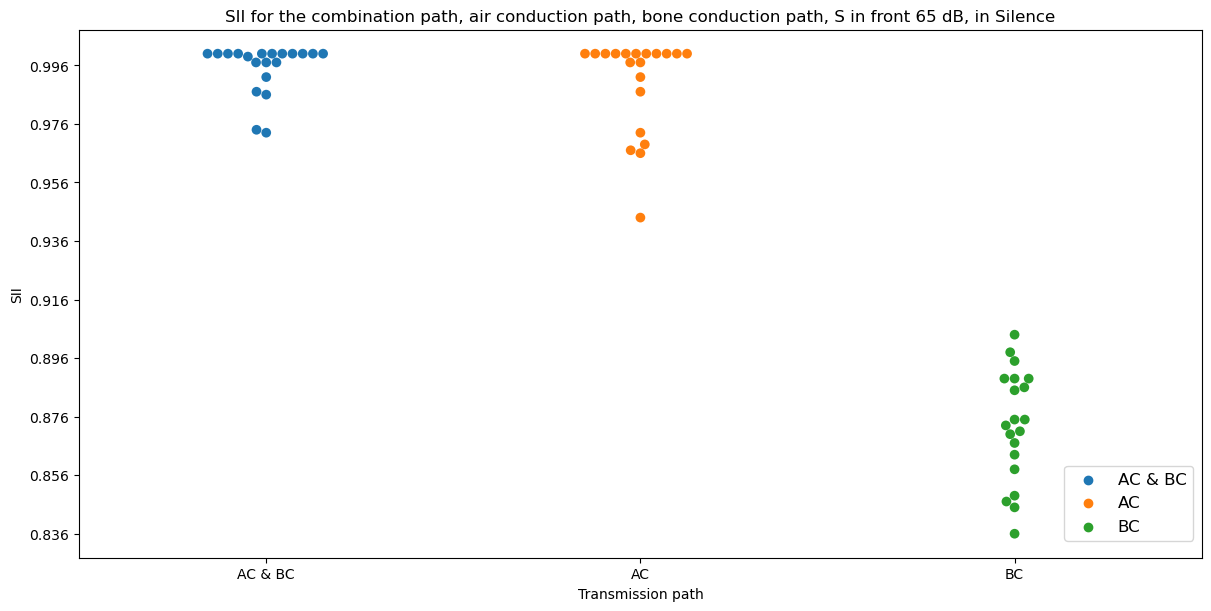

In [13]:
# make a figure to plot SII for the 3 paths
ttl = 'SII for the combination path, air conduction path, bone conduction path, S in front 65 dB, in Silence'
sii_combi = sii['AC&BC_path']
sii_ac = sii['AC_path']
sii_bc = sii['BC_path']
tp = pd.melt(pd.DataFrame( {'AC & BC' : sii_combi, 'AC' : sii_ac, 'BC' : sii_bc }), 
             var_name = 'Transmission path', value_name = 'SII') 

fig, ax = plt.subplots(constrained_layout=True)

sns.color_palette("colorblind")

fig.set_figheight(6)
fig.set_figwidth(12)

ax = sns.swarmplot(data = tp, x = 'Transmission path', y = 'SII', hue = 'Transmission path', size=7)

ax.set_title(ttl)
ax.set_yticks(np.arange(np.min(score[:-1]), np.max(score[:-1]), 0.02))
plt.legend(bbox_to_anchor=(1, 0.19), fontsize='large')

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Graphs/SII_SfrontNnone.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

plt.show()  